In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# import urllib as ul
import numpy as np

from Bio import Entrez

import operator

import seaborn as sns

**Part One [25 marks]**

 - 15 marks for successfully completing the tasks.
 - up to 6 marks for including one additional piece of analysis.
 - up to 4 marks for exceptionally well organised and executed approach.

First, download the SFARI gene list from https://gene.sfari.org/database/human-gene/

## Task 1

Plot a bar chart of the number of genes in each SFARI gene-score category (2 marks). 

In [2]:
SFARI_gene = pd.read_csv('SFARI-Gene_genes_10-29-2020release_11-22-2020export.csv')

SFARI_gene.head()

,status,gene-symbol,gene-name,ensembl-id,chromosome,genetic-category,gene-score,syndromic,number-of-reports
0,9,ABAT,4-aminobutyrate aminotransferase,ENSG00000183044,16,"Rare Single Gene Mutation, Genetic Association",3.0,0,5
1,9,ABCA10,"ATP-binding cassette, sub-family A (ABC1), mem...",ENSG00000154263,17,Rare Single Gene Mutation,3.0,0,1
2,9,ABCA13,ATP binding cassette subfamily A member 13,ENSG00000179869,7,"Rare Single Gene Mutation, Functional",3.0,0,6
3,9,ABCA7,"ATP-binding cassette, sub-family A (ABC1), mem...",ENSG00000064687,19,Rare Single Gene Mutation,3.0,0,4
4,9,ACE,angiotensin I converting enzyme,ENSG00000159640,17,"Rare Single Gene Mutation, Genetic Association",3.0,0,3


In [3]:
SFARI_gene_counts = pd.DataFrame(SFARI_gene.groupby('gene-score').size())

# SFARI_gene_counts.index = [i for i in SFARI_gene_counts.index]

SFARI_gene_counts.columns = ['count']

SFARI_gene_counts

,count
gene-score,
1.0,194
2.0,207
3.0,507


(array([0, 1, 2]), <a list of 3 Text major ticklabel objects>)

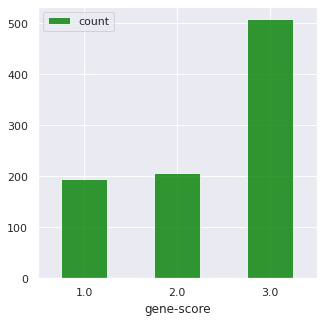

In [5]:
sns.set(rc={'figure.figsize':(5, 5)})
SFARI_gene_counts.plot.bar(color = 'green', alpha=0.8)
plt.xticks(rotation = 0)

## Task 2

Rank the genes by ‘number-of-reports’ and find the top 5 SFARI genes that are in gene-score category 1 (2 marks). 

In [6]:
SFARI_gene_rank = SFARI_gene.sort_values(['number-of-reports'], ascending = False).loc[SFARI_gene['gene-score'] == 1]

gene_top_5 = SFARI_gene_rank.head()
gene_top_5.index = [i for i in range(len(gene_top_5))]

gene_top_5

,status,gene-symbol,gene-name,ensembl-id,chromosome,genetic-category,gene-score,syndromic,number-of-reports
0,9,SHANK3,SH3 and multiple ankyrin repeat domains 3,ENSG00000251322,22,"Rare Single Gene Mutation, Syndromic, Genetic ...",1.0,0,88
1,9,NRXN1,neurexin 1,ENSG00000179915,2,"Rare Single Gene Mutation, Syndromic, Genetic ...",1.0,0,88
2,9,MECP2,Methyl CpG binding protein 2,ENSG00000169057,X,"Rare Single Gene Mutation, Syndromic, Functional",1.0,0,87
3,9,SCN2A,"sodium channel, voltage-gated, type II, alpha ...",ENSG00000136531,2,"Rare Single Gene Mutation, Syndromic",1.0,0,71
4,9,SCN1A,"sodium channel, voltage-gated, type I, alpha s...",ENSG00000144285,2,"Rare Single Gene Mutation, Syndromic, Genetic ...",1.0,0,67


In [7]:
SFARI_gene_rank.to_excel('SFARI_gene_rank.xls')

## Task 3

For each of these genes find the number of papers in PubMed that include the gene AND are related to Autism (5 marks).

The MeSH Major Topic is not just picking up papers that have autism as a wordnecessarily in it. It's picking up any paper that has been annotated with the mesh keywords that live within that part of the mesh annotation table. 

And I not only included the gene symbol but also the gene name by using ("gene-symbol" OR "gene-name"). 

In [8]:
Entrez.email = "954427089@qq.com" # You should replace this with your e-mail address 

gene_counts = {}

for i in range(len(gene_top_5)):
    term = 'autism'+'[MAJR] AND ("' + gene_top_5.loc[i, 'gene-symbol'] + '" OR "' + gene_top_5.loc[i, 'gene-name'] + '")'
    print(term)
    handle = Entrez.egquery(term = term)
    record = Entrez.read(handle)
    handle.close()
#     print(record)
    for row in record["eGQueryResult"]:
        if row["DbName"]=="pubmed":
            gene_counts[gene_top_5.loc[i, 'gene-symbol']] = int(row["Count"])

print(gene_counts)

autism[MAJR] AND ("SHANK3" OR "SH3 and multiple ankyrin repeat domains 3")
autism[MAJR] AND ("NRXN1" OR "neurexin 1")
autism[MAJR] AND ("MECP2" OR "Methyl CpG binding protein 2")
autism[MAJR] AND ("SCN2A" OR "sodium channel, voltage-gated, type II, alpha subunit")
autism[MAJR] AND ("SCN1A" OR "sodium channel, voltage-gated, type I, alpha subunit")
{'SHANK3': 65, 'NRXN1': 37, 'MECP2': 80, 'SCN2A': 12, 'SCN1A': 11}


## Task 4

From these data fill a table with genes as rows and paper count by year as column (3 marks).

As it is discussed in the discussion, some paper may have different version or last for more than one year. I just changed [DP] to [DCOM] which means the Completion Date pf the paper so that one paper only be counted for once. The sum of papers on each gene matches the total number of papers which can approve it. 

In [9]:
counts_by_year = pd.DataFrame()

for i in range(len(gene_top_5)):
    year_counts = {}
    
    print(gene_top_5.loc[i, 'gene-symbol'])
    
    # note the egquery function provides Entrez database counts from a global search.
    for j in range(2000,2021,1):
        term = 'autism'+'[MAJR] AND ("' + gene_top_5.loc[i, 'gene-symbol'] + '" OR "' + gene_top_5.loc[i, 'gene-name'] + '") AND ' + str(j) + '[DCOM]'
#         print(term)
        handle = Entrez.egquery(term = term)
        record = Entrez.read(handle)
        handle.close()
        # we can iterate through the record and only return the 'nucleotide' result
        for row in record["eGQueryResult"]:
            if row["DbName"]=="pubmed":
                year_counts[j] = int(row["Count"])
    
    counts_by_year = counts_by_year.append(year_counts, ignore_index = True)

counts_by_year.index = [gene_top_5.loc[i, 'gene-symbol'] for i in range(len(gene_top_5))]
counts_by_year.head()

SHANK3
NRXN1
MECP2
SCN2A
SCN1A


,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
SHANK3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,5.0,9.0,...,5.0,8.0,4.0,1.0,1.0,4.0,6.0,6.0,9.0,5.0
NRXN1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,5.0,...,1.0,4.0,3.0,4.0,6.0,1.0,2.0,1.0,2.0,2.0
MECP2,0.0,2.0,1.0,4.0,2.0,7.0,2.0,3.0,7.0,7.0,...,2.0,5.0,5.0,5.0,2.0,7.0,5.0,5.0,0.0,1.0
SCN2A,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,...,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,3.0,0.0
SCN1A,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,1.0,...,0.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0


In [10]:
counts_by_year.to_excel('counts_by_year.xls')

## Task 5

Plot a single stacked histogram displaying the data from the table (3 marks).

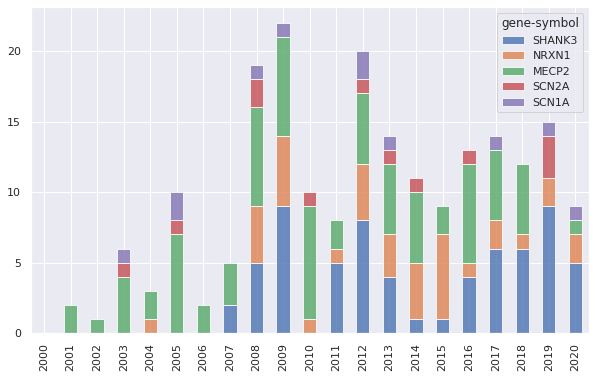

In [11]:
sns.set(rc={'figure.figsize':(10, 6)})

counts_by_year = pd.read_excel('counts_by_year.xls')
counts_by_year.columns = ['gene-symbol'] + [i for i in range(2000, 2021, 1)]

counts_by_year_T = pd.DataFrame(counts_by_year.values.T, columns = counts_by_year['gene-symbol'], index = [0] + [i for i in range(2000, 2021, 1)]).drop([0])
counts_by_year_T.head()

counts_by_year_T.plot.bar(stacked = True, figsize = (10, 6), alpha=0.8)

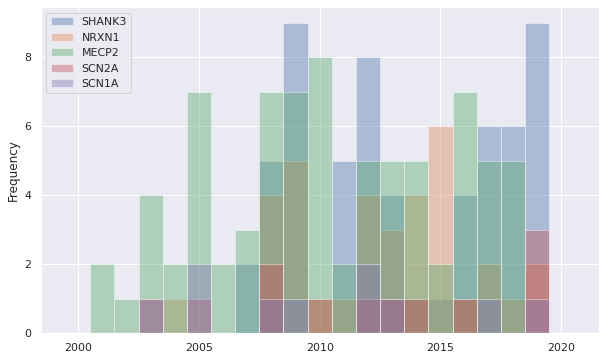

In [15]:
counts_by_year_2 = pd.DataFrame()

for i in range(len(counts_by_year)):
    for j in range(2000, 2020, 1):
        for k in range(counts_by_year.loc[i, j]):
            counts_by_year_2 = counts_by_year_2.append({counts_by_year.loc[i, 'gene-symbol']: int(j)}, ignore_index = True)

counts_by_year_2.plot.hist(figsize = (10, 6), bins = [i - 0.5 for i in range(2000, 2022)], alpha=0.4)

## additional piece of analysis - 1

In [12]:
gene_after_5 = SFARI_gene_rank.iloc[5:]
gene_after_5.index = [i for i in range(len(gene_after_5))]

gene_after_5.head()

,status,gene-symbol,gene-name,ensembl-id,chromosome,genetic-category,gene-score,syndromic,number-of-reports
0,9,PTEN,phosphatase and tensin homolog (mutated in mul...,ENSG00000171862,10,"Rare Single Gene Mutation, Syndromic, Functional",1.0,0,63
1,9,SYNGAP1,synaptic Ras GTPase activating protein 1,ENSG00000197283,6,"Rare Single Gene Mutation, Syndromic",1.0,0,60
2,9,CHD8,chromodomain helicase DNA binding protein 8,ENSG00000100888,14,"Rare Single Gene Mutation, Syndromic, Functional",1.0,0,57
3,9,GRIN2B,"glutamate receptor, inotropic, N-methyl D-apar...",ENSG00000273079,12,"Rare Single Gene Mutation, Syndromic, Genetic ...",1.0,0,56
4,9,RELN,Reelin,ENSG00000189056,7,"Rare Single Gene Mutation, Syndromic, Genetic ...",1.0,0,53


In [20]:
counts_after_5 = {}

for i in range(len(gene_after_5)):
    term = 'autism'+'[MAJR] AND ("' + gene_after_5.loc[i, 'gene-symbol'] + '" OR "' + gene_after_5.loc[i, 'gene-name'] + '") AND 0:2000[DP]'
    print(term)
    handle = Entrez.egquery(term = term)
    record = Entrez.read(handle)
    handle.close()
    for row in record["eGQueryResult"]:
        if row["DbName"]=="pubmed":
            counts_after_5[gene_after_5.loc[i, 'gene-symbol']] = int(row["Count"])

print(counts_after_5)

autism[MAJR] AND ("PTEN" OR "phosphatase and tensin homolog (mutated in multiple advanced cancers 1)") AND 0:2000[DP]
autism[MAJR] AND ("SYNGAP1" OR "synaptic Ras GTPase activating protein 1") AND 0:2000[DP]
autism[MAJR] AND ("CHD8" OR "chromodomain helicase DNA binding protein 8") AND 0:2000[DP]
autism[MAJR] AND ("GRIN2B" OR "glutamate receptor, inotropic, N-methyl D-apartate 2B") AND 0:2000[DP]
autism[MAJR] AND ("RELN" OR "Reelin") AND 0:2000[DP]
autism[MAJR] AND ("ARID1B" OR "AT-rich interaction domain 1B") AND 0:2000[DP]
autism[MAJR] AND ("FOXP1" OR "forkhead box P1") AND 0:2000[DP]
autism[MAJR] AND ("DYRK1A" OR "Dual-specificity tyrosine-(Y)-phosphorylation regulated kinase 1A") AND 0:2000[DP]
autism[MAJR] AND ("TCF4" OR "Transcription factor 4") AND 0:2000[DP]
autism[MAJR] AND ("CACNA1C" OR "calcium channel, voltage-dependent, L type, alpha 1C subunit") AND 0:2000[DP]
autism[MAJR] AND ("ANKRD11" OR "ankyrin repeat domain 11") AND 0:2000[DP]
autism[MAJR] AND ("STXBP1" OR "Syntaxin

autism[MAJR] AND ("PTCHD1" OR "patched domain containing 1") AND 0:2000[DP]
autism[MAJR] AND ("LZTR1" OR "Leucine-zipper-like transcription regulator 1") AND 0:2000[DP]
autism[MAJR] AND ("NRXN2" OR "neurexin 2") AND 0:2000[DP]
autism[MAJR] AND ("ALDH5A1" OR "aldehyde dehydrogenase 5 family, member A1 (succinate-semialdehyde dehydrogenase )") AND 0:2000[DP]
autism[MAJR] AND ("DSCAM" OR "Down syndrome cell adhesion molecule") AND 0:2000[DP]
autism[MAJR] AND ("CELF4" OR "CUGBP, Elav-like family member 4") AND 0:2000[DP]
autism[MAJR] AND ("MBOAT7" OR "membrane bound O-acyltransferase domain containing 7") AND 0:2000[DP]
autism[MAJR] AND ("PHF21A" OR "PHD finger protein 21A") AND 0:2000[DP]
autism[MAJR] AND ("TANC2" OR "etratricopeptide repeat, ankyrin repeat and coiled-coil containing 2") AND 0:2000[DP]
autism[MAJR] AND ("KMT2E" OR "Lysine (K)-specific methyltransferase 2E") AND 0:2000[DP]
autism[MAJR] AND ("KCNQ3" OR "potassium voltage-gated channel subfamily Q member 3") AND 0:2000[DP]
a

In [36]:
counts_nonzero = {}

for key in counts_after_5.keys():
    if counts_after_5[key] > 0:
        counts_nonzero[key] = counts_after_5[key]

with open('counts_after_5_before_2000.csv', 'w') as f:
    for key in counts_nonzero.keys():
        f.write("%s, %s\n"%(key, counts_nonzero[key]))

counts_nonzero

{'FMR1': 7,
 'GABRB3': 7,
 'TSC2': 1,
 'UBE3A': 3,
 'NF1': 1,
 'HRAS': 3,
 'SON': 38,
 'ADSL': 8,
 'TEK': 3,
 'GFAP': 3}

In [4]:
counts_nonzero = pd.read_csv('counts_after_5_before_2000.csv')

counts_nonzero

,FMR1,7
0,GABRB3,7
1,TSC2,1
2,UBE3A,3
3,NF1,1
4,HRAS,3
5,SON,38
6,ADSL,8
7,TEK,3
8,GFAP,3


## additional piece of analysis - 2

In [5]:
SFARI_gene_rank = pd.read_excel('SFARI_gene_rank.xls')

In [7]:
SFARI_gene_rank_2 = SFARI_gene_rank.loc[SFARI_gene_rank['number-of-reports'] > 10]

counts_2019 = {}

for i in range(len(SFARI_gene_rank_2)):
    term = 'autism'+'[MAJR] AND ("' + SFARI_gene_rank_2.loc[i, 'gene-symbol'] + '" OR "' + SFARI_gene_rank_2.loc[i, 'gene-name'] + '") AND 2019[DP]'
    print(term)
    handle = Entrez.egquery(term = term)
    record = Entrez.read(handle)
    handle.close()
    for row in record["eGQueryResult"]:
        if row["DbName"]=="pubmed":
            counts_2019[SFARI_gene_rank_2.loc[i, 'gene-symbol']] = int(row["Count"])

print(counts_2019)

autism[MAJR] AND ("SHANK3" OR "SH3 and multiple ankyrin repeat domains 3") AND 2019[DP]


/home/anonymous/anaconda3/lib/python3.8/site-packages/Bio/Entrez/__init__.py:658: UserWarning: 
Email address is not specified.

To make use of NCBI's E-utilities, NCBI requires you to specify your
email address with each request.  As an example, if your email address
is A.N.Other@example.com, you can specify it as follows:
   from Bio import Entrez
   Entrez.email = 'A.N.Other@example.com'
In case of excessive usage of the E-utilities, NCBI will attempt to contact
a user at the email address provided before blocking access to the
E-utilities.
  warnings.warn(


autism[MAJR] AND ("NRXN1" OR "neurexin 1") AND 2019[DP]
autism[MAJR] AND ("MECP2" OR "Methyl CpG binding protein 2") AND 2019[DP]
autism[MAJR] AND ("SCN2A" OR "sodium channel, voltage-gated, type II, alpha subunit") AND 2019[DP]
autism[MAJR] AND ("SCN1A" OR "sodium channel, voltage-gated, type I, alpha subunit") AND 2019[DP]
autism[MAJR] AND ("PTEN" OR "phosphatase and tensin homolog (mutated in multiple advanced cancers 1)") AND 2019[DP]
autism[MAJR] AND ("SYNGAP1" OR "synaptic Ras GTPase activating protein 1") AND 2019[DP]
autism[MAJR] AND ("CHD8" OR "chromodomain helicase DNA binding protein 8") AND 2019[DP]
autism[MAJR] AND ("GRIN2B" OR "glutamate receptor, inotropic, N-methyl D-apartate 2B") AND 2019[DP]
autism[MAJR] AND ("RELN" OR "Reelin") AND 2019[DP]
autism[MAJR] AND ("ARID1B" OR "AT-rich interaction domain 1B") AND 2019[DP]
autism[MAJR] AND ("FOXP1" OR "forkhead box P1") AND 2019[DP]
autism[MAJR] AND ("DYRK1A" OR "Dual-specificity tyrosine-(Y)-phosphorylation regulated kinase

autism[MAJR] AND ("DLG4" OR "discs large MAGUK scaffold protein 4") AND 2019[DP]
autism[MAJR] AND ("AHDC1" OR "AT-hook DNA binding motif containing 1") AND 2019[DP]
autism[MAJR] AND ("PTCHD1" OR "patched domain containing 1") AND 2019[DP]
autism[MAJR] AND ("LZTR1" OR "Leucine-zipper-like transcription regulator 1") AND 2019[DP]
autism[MAJR] AND ("NRXN2" OR "neurexin 2") AND 2019[DP]
autism[MAJR] AND ("ALDH5A1" OR "aldehyde dehydrogenase 5 family, member A1 (succinate-semialdehyde dehydrogenase )") AND 2019[DP]
autism[MAJR] AND ("DSCAM" OR "Down syndrome cell adhesion molecule") AND 2019[DP]
autism[MAJR] AND ("CELF4" OR "CUGBP, Elav-like family member 4") AND 2019[DP]
{'SHANK3': 5, 'NRXN1': 4, 'MECP2': 1, 'SCN2A': 1, 'SCN1A': 0, 'PTEN': 2, 'SYNGAP1': 0, 'CHD8': 1, 'GRIN2B': 0, 'RELN': 1, 'ARID1B': 0, 'FOXP1': 1, 'DYRK1A': 1, 'TCF4': 0, 'CACNA1C': 5, 'ANKRD11': 0, 'STXBP1': 0, 'FMR1': 5, 'ADNP': 1, 'FOXP2': 1, 'AUTS2': 1, 'CHD2': 0, 'GABRB3': 0, 'PCDH19': 1, 'CDKL5': 1, 'NLGN3': 2, 'SHAN

In [39]:
counts_2019_nonzero = {}

for key in counts_2019.keys():
    if counts_2019[key] > 0:
        counts_2019_nonzero[key] = counts_2019[key]

counts_2019_nonzero = dict(sorted(counts_2019_nonzero.items(), key = operator.itemgetter(1), reverse = True))

# with open('counts_2019.csv', 'w') as f:
#     for key in counts_2019_nonzero.keys():
#         f.write("%s, %s\n"%(key, counts_2019_nonzero[key]))

counts_2019_nonzero_2 = pd.DataFrame(columns = ['gene-symbol', 'counts-2019'])
for key in counts_2019_nonzero.keys():
    counts_2019_nonzero_2 = counts_2019_nonzero_2.append({'gene-symbol': key, 'counts-2019': counts_2019_nonzero[key]}, ignore_index=True)
counts_2019_nonzero_2

,gene-symbol,counts-2019
0,SHANK3,5
1,CACNA1C,5
2,FMR1,5
3,NRXN1,4
4,SHANK2,3
5,PTEN,2
6,NLGN3,2
7,DLG4,2
8,MECP2,1
9,SCN2A,1


In [17]:
SFARI_gene_rank_2 = SFARI_gene_rank.loc[SFARI_gene_rank['number-of-reports'] > 10]

counts_2020 = {}

for i in range(len(SFARI_gene_rank_2)):
    term = 'autism'+'[MAJR] AND ("' + SFARI_gene_rank_2.loc[i, 'gene-symbol'] + '" OR "' + SFARI_gene_rank_2.loc[i, 'gene-name'] + '") AND 2020[DP]'
    print(term)
    handle = Entrez.egquery(term = term)
    record = Entrez.read(handle)
    handle.close()
    for row in record["eGQueryResult"]:
        if row["DbName"]=="pubmed":
            counts_2020[SFARI_gene_rank_2.loc[i, 'gene-symbol']] = int(row["Count"])

print(counts_2020)

autism[MAJR] AND ("SHANK3" OR "SH3 and multiple ankyrin repeat domains 3") AND 2020[DP]


/home/anonymous/anaconda3/lib/python3.8/site-packages/Bio/Entrez/__init__.py:658: UserWarning: 
Email address is not specified.

To make use of NCBI's E-utilities, NCBI requires you to specify your
email address with each request.  As an example, if your email address
is A.N.Other@example.com, you can specify it as follows:
   from Bio import Entrez
   Entrez.email = 'A.N.Other@example.com'
In case of excessive usage of the E-utilities, NCBI will attempt to contact
a user at the email address provided before blocking access to the
E-utilities.
  warnings.warn(


autism[MAJR] AND ("NRXN1" OR "neurexin 1") AND 2020[DP]
autism[MAJR] AND ("MECP2" OR "Methyl CpG binding protein 2") AND 2020[DP]
autism[MAJR] AND ("SCN2A" OR "sodium channel, voltage-gated, type II, alpha subunit") AND 2020[DP]
autism[MAJR] AND ("SCN1A" OR "sodium channel, voltage-gated, type I, alpha subunit") AND 2020[DP]
autism[MAJR] AND ("PTEN" OR "phosphatase and tensin homolog (mutated in multiple advanced cancers 1)") AND 2020[DP]
autism[MAJR] AND ("SYNGAP1" OR "synaptic Ras GTPase activating protein 1") AND 2020[DP]
autism[MAJR] AND ("CHD8" OR "chromodomain helicase DNA binding protein 8") AND 2020[DP]
autism[MAJR] AND ("GRIN2B" OR "glutamate receptor, inotropic, N-methyl D-apartate 2B") AND 2020[DP]
autism[MAJR] AND ("RELN" OR "Reelin") AND 2020[DP]
autism[MAJR] AND ("ARID1B" OR "AT-rich interaction domain 1B") AND 2020[DP]
autism[MAJR] AND ("FOXP1" OR "forkhead box P1") AND 2020[DP]
autism[MAJR] AND ("DYRK1A" OR "Dual-specificity tyrosine-(Y)-phosphorylation regulated kinase

autism[MAJR] AND ("DLG4" OR "discs large MAGUK scaffold protein 4") AND 2020[DP]
autism[MAJR] AND ("AHDC1" OR "AT-hook DNA binding motif containing 1") AND 2020[DP]
autism[MAJR] AND ("PTCHD1" OR "patched domain containing 1") AND 2020[DP]
autism[MAJR] AND ("LZTR1" OR "Leucine-zipper-like transcription regulator 1") AND 2020[DP]
autism[MAJR] AND ("NRXN2" OR "neurexin 2") AND 2020[DP]
autism[MAJR] AND ("ALDH5A1" OR "aldehyde dehydrogenase 5 family, member A1 (succinate-semialdehyde dehydrogenase )") AND 2020[DP]
autism[MAJR] AND ("DSCAM" OR "Down syndrome cell adhesion molecule") AND 2020[DP]
autism[MAJR] AND ("CELF4" OR "CUGBP, Elav-like family member 4") AND 2020[DP]
{'SHANK3': 3, 'NRXN1': 0, 'MECP2': 1, 'SCN2A': 0, 'SCN1A': 1, 'PTEN': 3, 'SYNGAP1': 0, 'CHD8': 0, 'GRIN2B': 0, 'RELN': 0, 'ARID1B': 0, 'FOXP1': 0, 'DYRK1A': 0, 'TCF4': 0, 'CACNA1C': 0, 'ANKRD11': 0, 'STXBP1': 0, 'FMR1': 2, 'ADNP': 0, 'FOXP2': 0, 'AUTS2': 0, 'CHD2': 0, 'GABRB3': 0, 'PCDH19': 0, 'CDKL5': 1, 'NLGN3': 1, 'SHAN

In [40]:
counts_2020_nonzero = {}

for key in counts_2020.keys():
    if counts_2020[key] > 0:
        counts_2020_nonzero[key] = counts_2020[key]

counts_2020_nonzero = dict(sorted(counts_2020_nonzero.items(), key = operator.itemgetter(1), reverse = True))

# with open('counts_2020.csv', 'w') as f:
#     for key in counts_2020_nonzero.keys():
#         f.write("%s, %s\n"%(key, counts_2020_nonzero[key]))

counts_2020_nonzero_2 = pd.DataFrame(columns = ['gene-symbol', 'counts-2020'])
for key in counts_2020_nonzero.keys():
    counts_2020_nonzero_2 = counts_2020_nonzero_2.append({'gene-symbol': key, 'counts-2020': counts_2020_nonzero[key]}, ignore_index=True)
counts_2020_nonzero_2

,gene-symbol,counts-2020
0,SHANK3,3
1,PTEN,3
2,FMR1,2
3,MECP2,1
4,SCN1A,1
5,CDKL5,1
6,NLGN3,1
7,POGZ,1
8,DEAF1,1
9,PTCHD1,1


In [38]:
counts_2019_2020 = pd.merge(counts_2019_nonzero_2, counts_2020_nonzero_2, on = 'gene-symbol')
counts_2019_2020.to_excel('counts_2019_2020.xls')
counts_2019_2020

,gene-symbol,counts-2019,counts-2020
0,SHANK3,5,3
1,FMR1,5,2
2,PTEN,2,3
3,NLGN3,2,1
4,MECP2,1,1
5,CDKL5,1,1
6,DEAF1,1,1


## Requirement

Comment on your results. You might want to think about the timescale over which papers have appeared, how different genes have fared over the years, how representative these 5 genes might be. Other factors to consider might be; how confident are you that the papers you have identified are related to Autism and why?

Possible extensions here might be to look at citation data, extend to more of the genes or even all of them.

## Colclusion

Among the top 5 genes, though it does not have the largest number of papers, *MECP2* appeared the earliest but the number of papers related to it is not very significant since 2019. *SCN1A* also appeared early but the number of papers stayed low over the years and so did gene *SCN2A*. As for *NRXN1* and *SHANK3*, which are the top 2 SFARI genes, the number of papers increased from 2007 and are still very significant. 

The genes are fairly representative. Since they inclde the genes that is related to the largest numbers of papers about autism which means they are most likely to be crucial to autism. And the time covered the most period of the history of the research about the relationship of autism and genes.[1] 

However, it is still not sufficient. Firstly, there are still some genes with a raletively large numbers of papers for example, *PTEN* has 63 results which is just 4 papers less than *SCN1A*. Secondly, there are also many genes that is discovered to be related to autism siince a very early time such as *PTEN* and *RELN*. In fact, from additional piece of analysis 1, there are 10 genes that have papers related to autism before 2000 which is earlier than the most earliest paper of the top 5 genes, and there are even genes with papers in 1990s: *FMR1* which is far earlier than the earliest time these 5 genes covered. What's more, from additional piece of analysis 2, there are still many genes beyond top 5 genes that have pepers related to autism in more recent years such as 2020 or 2019. The gene *CACNA1C* has though much less papers related to autism, the number of papers is increasing year by year which may be an avidence of relationship to autism. 

#### how confident are you that the papers you have identified are related to Autism and why?

-------

[1] Rylaarsdam, Lauren & Guemez-Gamboa, Alicia, 2019. Genetic Causes and Modifiers of Autism Spectrum Disorder. Frontiers in cellular neuroscience, 13, p.385.